In [ ]:
import tensorflow as tf
import numpy as np

import pandas as pd
import cv2
import os
import math
import scipy as sp
import PIL

# Tensorflow
from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB6, ResNet50V2
#from keras_tuner.tuners import RandomSearch

import scikitplot as skplt
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

In [ ]:
# batch_size: 한번에 forward & Backword 하는 샘플의 수
batch_size = 1

# Training 수
epochs = 50

# Weight 조절 parameter
LearningRate = 1e-3 # 0.001
Decay = 1e-6

img_width = 224
img_height = 224

In [ ]:
# 디렉토리 경로 설정 필요
CurrentDirectory = "./"

train_directory = CurrentDirectory + 'TRAIN/'
test_directory  = CurrentDirectory + 'TEST/'
model_directory = CurrentDirectory + 'MODEL/'
tensorboard_directory = CurrentDirectory + 'Tensorboard'

In [ ]:
# Online-augmentation 적용 Generator
# 1. 이미지를 전부다 불러서 램 (메모리)에 올릴 수 없기 때문
# 2. 이미지는 Augmentation을 해주는게 좋아서

DATAGEN_TRAIN = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last",
    validation_split=0.10) # Train / Validation

In [ ]:
TRAIN_GENERATOR = DATAGEN_TRAIN.flow_from_directory(
    train_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode= "categorical",
    subset = "training")

Found 486 images belonging to 2 classes.


In [ ]:
# Image는 0 ~ 1 사이 값이어야 plot이 가능함
item = TRAIN_GENERATOR.__getitem__(0)
print('item[0]:', item[0].shape)
print('item[1]:', item[1].shape)
print('batch_index:', TRAIN_GENERATOR.batch_index)

item[0]: (1, 224, 224, 3)
item[1]: (1, 2)
batch_index: 0


In [ ]:
item[0][0]

array([[[0.6890808 , 0.543611  , 0.67805964],
        [0.6891884 , 0.5437545 , 0.6780955 ],
        [0.68929607, 0.54389805, 0.6781314 ],
        ...,
        [0.5776094 , 0.49832392, 0.6039216 ],
        [0.57746583, 0.49828807, 0.6039216 ],
        [0.5773223 , 0.49825218, 0.6039216 ]],

       [[0.6824172 , 0.52861464, 0.67052406],
        [0.68223774, 0.5286505 , 0.67070353],
        [0.68205833, 0.52868646, 0.67088294],
        ...,
        [0.5921569 , 0.5005407 , 0.60463166],
        [0.5921569 , 0.50061244, 0.6045958 ],
        [0.5921569 , 0.5006842 , 0.6045599 ]],

       [[0.6992618 , 0.52426773, 0.6573471 ],
        [0.6992259 , 0.52430356, 0.6572753 ],
        [0.69919   , 0.5243395 , 0.6572035 ],
        ...,
        [0.59556323, 0.49298224, 0.6089786 ],
        [0.5954556 , 0.49301812, 0.60894275],
        [0.59534794, 0.493054  , 0.60890687]],

       ...,

       [[0.5921569 , 0.47058827, 0.5294118 ],
        [0.5921569 , 0.47058827, 0.5294118 ],
        [0.5921569 , 0

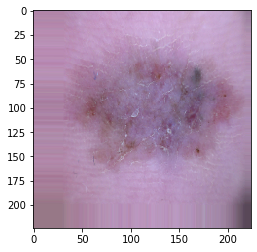

In [ ]:
plt.imshow(item[0][0], interpolation='nearest')
plt.show()

- 이미지가 돌아가 적용되지않은 나머지 부분이 주변에서 가져와 적용됨

In [ ]:
# Image는 0 ~ 1 사이 값이어야 plot이 가능함
item = TRAIN_GENERATOR.__getitem__(0)
print('item[0]:', item[0].shape)
print('item[1]:', item[1].shape)
print('batch_index:', TRAIN_GENERATOR.batch_index)

item[0]: (1, 224, 224, 3)
item[1]: (1, 2)
batch_index: 0


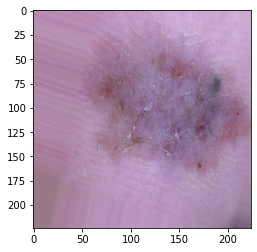

In [ ]:
plt.imshow(item[0][0], interpolation='nearest')
plt.show()

In [ ]:
DATAGEN_TEST = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last")
	
TEST_GENERATOR = DATAGEN_TEST.flow_from_directory(
    test_directory,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    shuffle = False,
    class_mode='categorical') 
# [1,0,0]
# [0,0,1]	
EfficientNet = tf.keras.applications.EfficientNetB7(include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_width,img_height,3), pooling=None)
x = GlobalAveragePooling2D()(EfficientNet.output)
predictions = Dense(3, activation='softmax')(x)
DeepLearning = Model(inputs=EfficientNet.input, outputs=predictions)


# Case
Binary classification.
-> 1. sigmoid로 구현을 할 때

    class_mode='binary' # 0 or 1 , finallayer = 1, sigmoid

-> 2. softmax로 구현을 할 때

    class_mode='categorical' # [1,0] 정상 [0,1] # 비정상, finallayer = 2, softmax


# case
3가지의 multi-class classification을 할 때
-> Event가 동시에 존재할 수 있는 Labels인 경우 
    # sigmoid 
    output 3개 모두 0~1 사이 값
    그래서 threshold가 각 각 
    output 1: 0.7 (0.6) # Output 1
    output 2: 0.6 (0.7) # X
    output 3: 0.8 (0.5) # output 3



-> Event가 동시에 존재할 수 없는 Labels인 경우 (전부다 아닌것도 존재할 수 없음)
    output layer activation : Softmax # [모든 output의 합이 1]
    output 1: 0.3
    output 2: 0.5 # -> output 2
    output 3: 0.2


10가지의 multi-class classification을 할 때
-> Event가 동시에 존재할 수 없는 Labels인 경우 (전부다 아닌것도 존재할 수 없음)
-> Event가 동시에 존재할 수 있는 Labels인 경우

